In [1]:
import bls_cpu as gbls
import utils_python.transitplot as transitp
import utils_python.transitfit as transitf
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import transitPy5 as tpy5
import numpy as np
from exotic_ld import StellarLimbDarkening

/home/aroy/venv/lib/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [29]:
# Get the data file
tic = 55849732
datadir = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1toiv2/tlc" + str(tic) + "/"
datafile = "tlc" + str(tic) + ".p.dat"

# Read it
phot = tpy5.readphot(datadir + datafile)

# Read stellar info
st_info = np.genfromtxt(datadir + "stellar_mast.dat")

freqs:  0.0056032261852297024 2.0
nstep:  148108


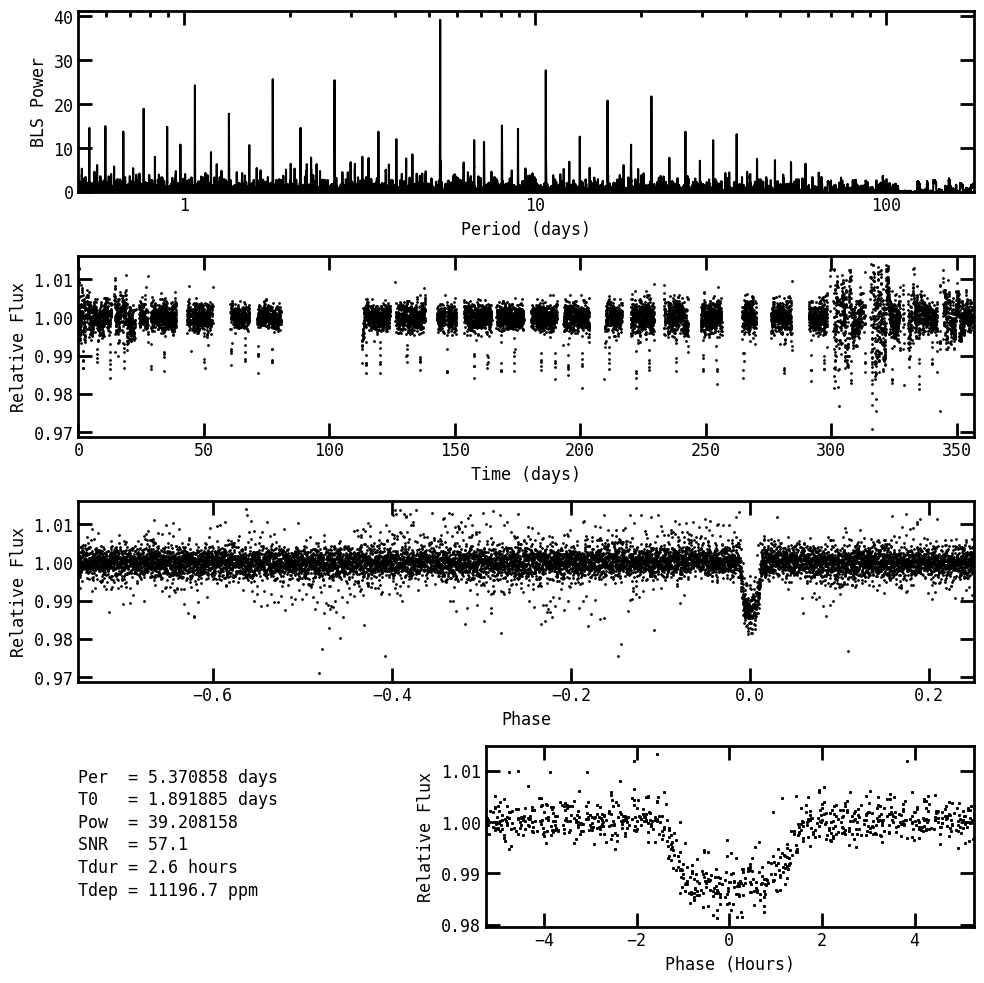

In [30]:
# Run BLS to find a transit
gbls_inputs = gbls.gbls_inputs_class()
gbls_inputs.zerotime = min(phot.time)
gbls_inputs.lcdir    = datadir
gbls_inputs.filename = datafile
gbls_ans = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

In [37]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = np.median(phot.flux)       # Photometric zero point
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)

# Find Kipping limb-darkening coefficients
M_H = st_info[7,1]
Teff = st_info[6,1]
logg = st_info[3,1]

ld_data_path = '/data2/rowe/exotic_ld_data/'
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [38]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

ρ (g/cm³):                      2.4662351 ± 178.1039148
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3034545 ± 0.0000000
q2:                             0.2605065 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         1.0000698 ± 0.0021018
t0 (days):                      1.8947941 ± 0.1016578
Period (days):                  5.3708347 ± 0.0029922
Impact parameter:               0.0178941 ± 1343.1544999
Rp/R*:                          0.1039675 ± 0.4185786
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


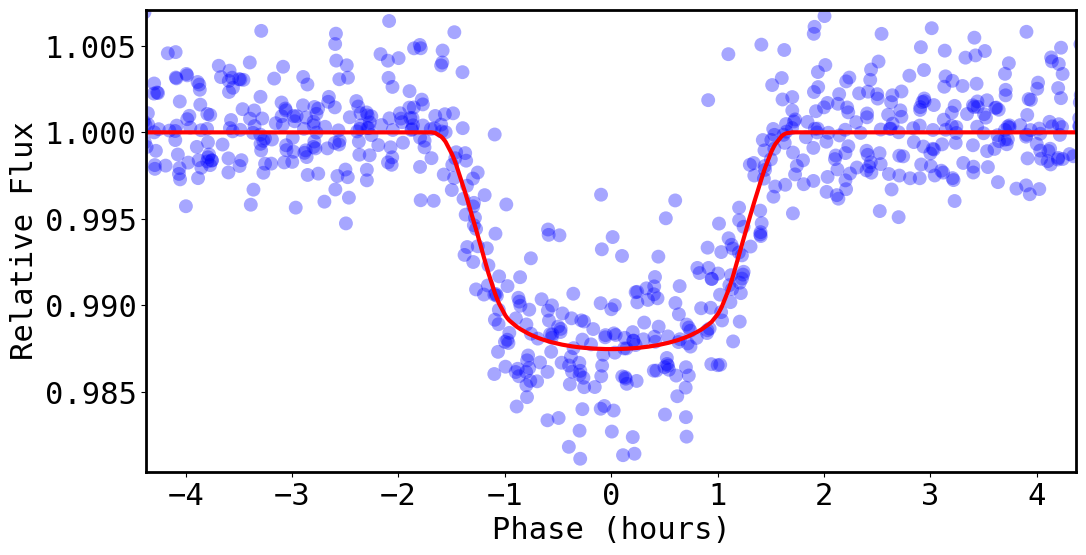

In [39]:
# Plotting
transitp.printParams(sol_fit)
transitp.plotTransit(phot, sol_fit)